# Phylogenetic reconstruction using R

In this course we will take a look at the phylogenetics of the bacterial representative OTU sequences obtained in the data processing part.

* First we will import and filter the sequences.

* After making the corresponding alignments we will perform different approaches to phylogenetic inference.

* Finally, we will visualize and interpret the results.

Import the R packages we will need. 

In [10]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("phangorn")
BiocManager::install("msa")

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'phangorn'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'biomaRt', 'broom', 'cachem', 'cluster', 'cpp11', 'data.table',
  'dbplyr', 'dplyr', 'forcats', 'knitr', 'lubridate', 'MASS', 'mgcv', 'mime',
  'partitions', 'pixmap', 'pkgload', 'promises', 'rappdirs', 'reprex',
  'rmarkdown', 'segmented', 'testthat', 'tibble', 'waldo', 'withr', 'xfun'



In [1]:
library(msa)
library(ggtree)
library(phangorn)
library(tidyverse)

Loading required package: Biostrings

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attac

## Sequence import  

Read the taxonomy file corresponding to the representative sequences using the `read_delim` function with the parameter `delim = "\t"` in order to fit the tab delimited format of the file.

In [2]:
taxonomy <- read_delim("otu_info/BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.cons.taxonomy", delim = "\t")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  OTU = col_character(),
  Size = col_double(),
  Taxonomy = col_character()
)




The created object is called `taxonomy`.

**Exercise**: type taxonomy in the code cell below and run it to inspect the object.

In [ ]:
# type your answer here

**Exercise**: how many columns are there in the object? How many rows? What do they represent?

*type your answer here*

Read the fasta file from the representative sequences using the the function `readDNAStringSet`.

In [4]:
bv5t <- readDNAStringSet("otu_info/BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.rep.fasta")

**Exercise**: inspect what the function `readDNAStringSet` does by adding `?` before the name of the function.

In [ ]:
## type here your answer 

**Exercise**: inspect the created object with the DNA sequences, called `bv5t`.

In [ ]:
## type your answer here 

### Change fasta names to taxonomy
Replace the names of the imported fasta object with the imported taxonomy. Since they are in the same order this can be simply done by replacing the `names` attribute from the `bv5t` fasta object with the `Taxonomy` column from the `taxonomy` dataframe. To prevent problems further on we also rename the duplicated taxonomy descriptions using the `make.unique` function.

In [6]:
names(bv5t) <- make.unique(taxonomy$Taxonomy)

Take only the sequences annotated as bacterial, that is, those that start with "k__Bacteria(100)" from the `bv5t` fasta object and name it as `bv5`.

In [8]:
bv5 <- bv5t[startsWith(names(bv5t), "k__Bacteria(100)")]

Remove bacteria from name to be able to identify the phyla more easily. We do this by substracting the 21 first characters using the `substring` function with the parameter `first = 21`. 

In [10]:
names(bv5) <- substring(names(bv5), first = 21)

**Exercise**: how many OTU's are deleted?

*hint: you may need to inspect both `bv5` and `bv5t` objects*

In [ ]:
# type your answer here

## Alignment

![](figs/align.png)

> **Evolution and the true multiple sequence alignment.** The top sequence evolves into the bottom sequence via the deletion of the substring GGTG, the substitution of a T for a C, and the insertion of a T. This corresponds to the pairwise alignment on the right. Note that two letters are placed in the same column only when they have a common history. Thus, the substring GGTG in the top string is above dashes in the bottom string, and indicates that deletion event. Similarly, the red T is above the blue C, to indicate that they have a common history. 

Align sequences using `msa` function (this may take a bit of time).

In [16]:
bv5_aligned = msa(bv5)

use default substitution matrix


**Exercise**: inspect the function `msa`. Which alignment algorithm was used? How would you use a different algorithm?

In [ ]:
## type your answer here

**Exercise**: inspect the object containing the alignment. What information can you get from it?

In [ ]:
# type your answer here

## Phylogenetic tree reconstruction

Parse to phangorn format.

In [18]:
alignment <- as.phyDat(bv5_aligned)

**Exercise**: inspect the alignment object.

In [ ]:
# type your answer here

## Distance based methods

> Distance methods try to fit a tree to a matrix of pairwise genetic distances.

Advantage:
- Fast speed of calculation

Disadvantages:
- Often not accurate (particularly in highly divergent sequences)
- Loss of evolutionary information

### **Cluster analysis**
**UPGMA** (unweighted pair group method with arithmetic means)
![](figs/upgma1.png)
![](figs/upgma2.png)

### **Minimum evolution**
**Neighbour Joining**
![](figs/nj.svg.png)

Construct a rooted tree using UPGMA and an unrooted one using NJ (Neighbour-joining).

In [19]:
dm <- dist.ml(alignment)
treeUPGMA  <- upgma(dm)
treeNJ  <- NJ(dm)

Visualize the tree with the tip names in small font using the `ggtree` package. The `geom_tip` adds the layer of leaf tips.

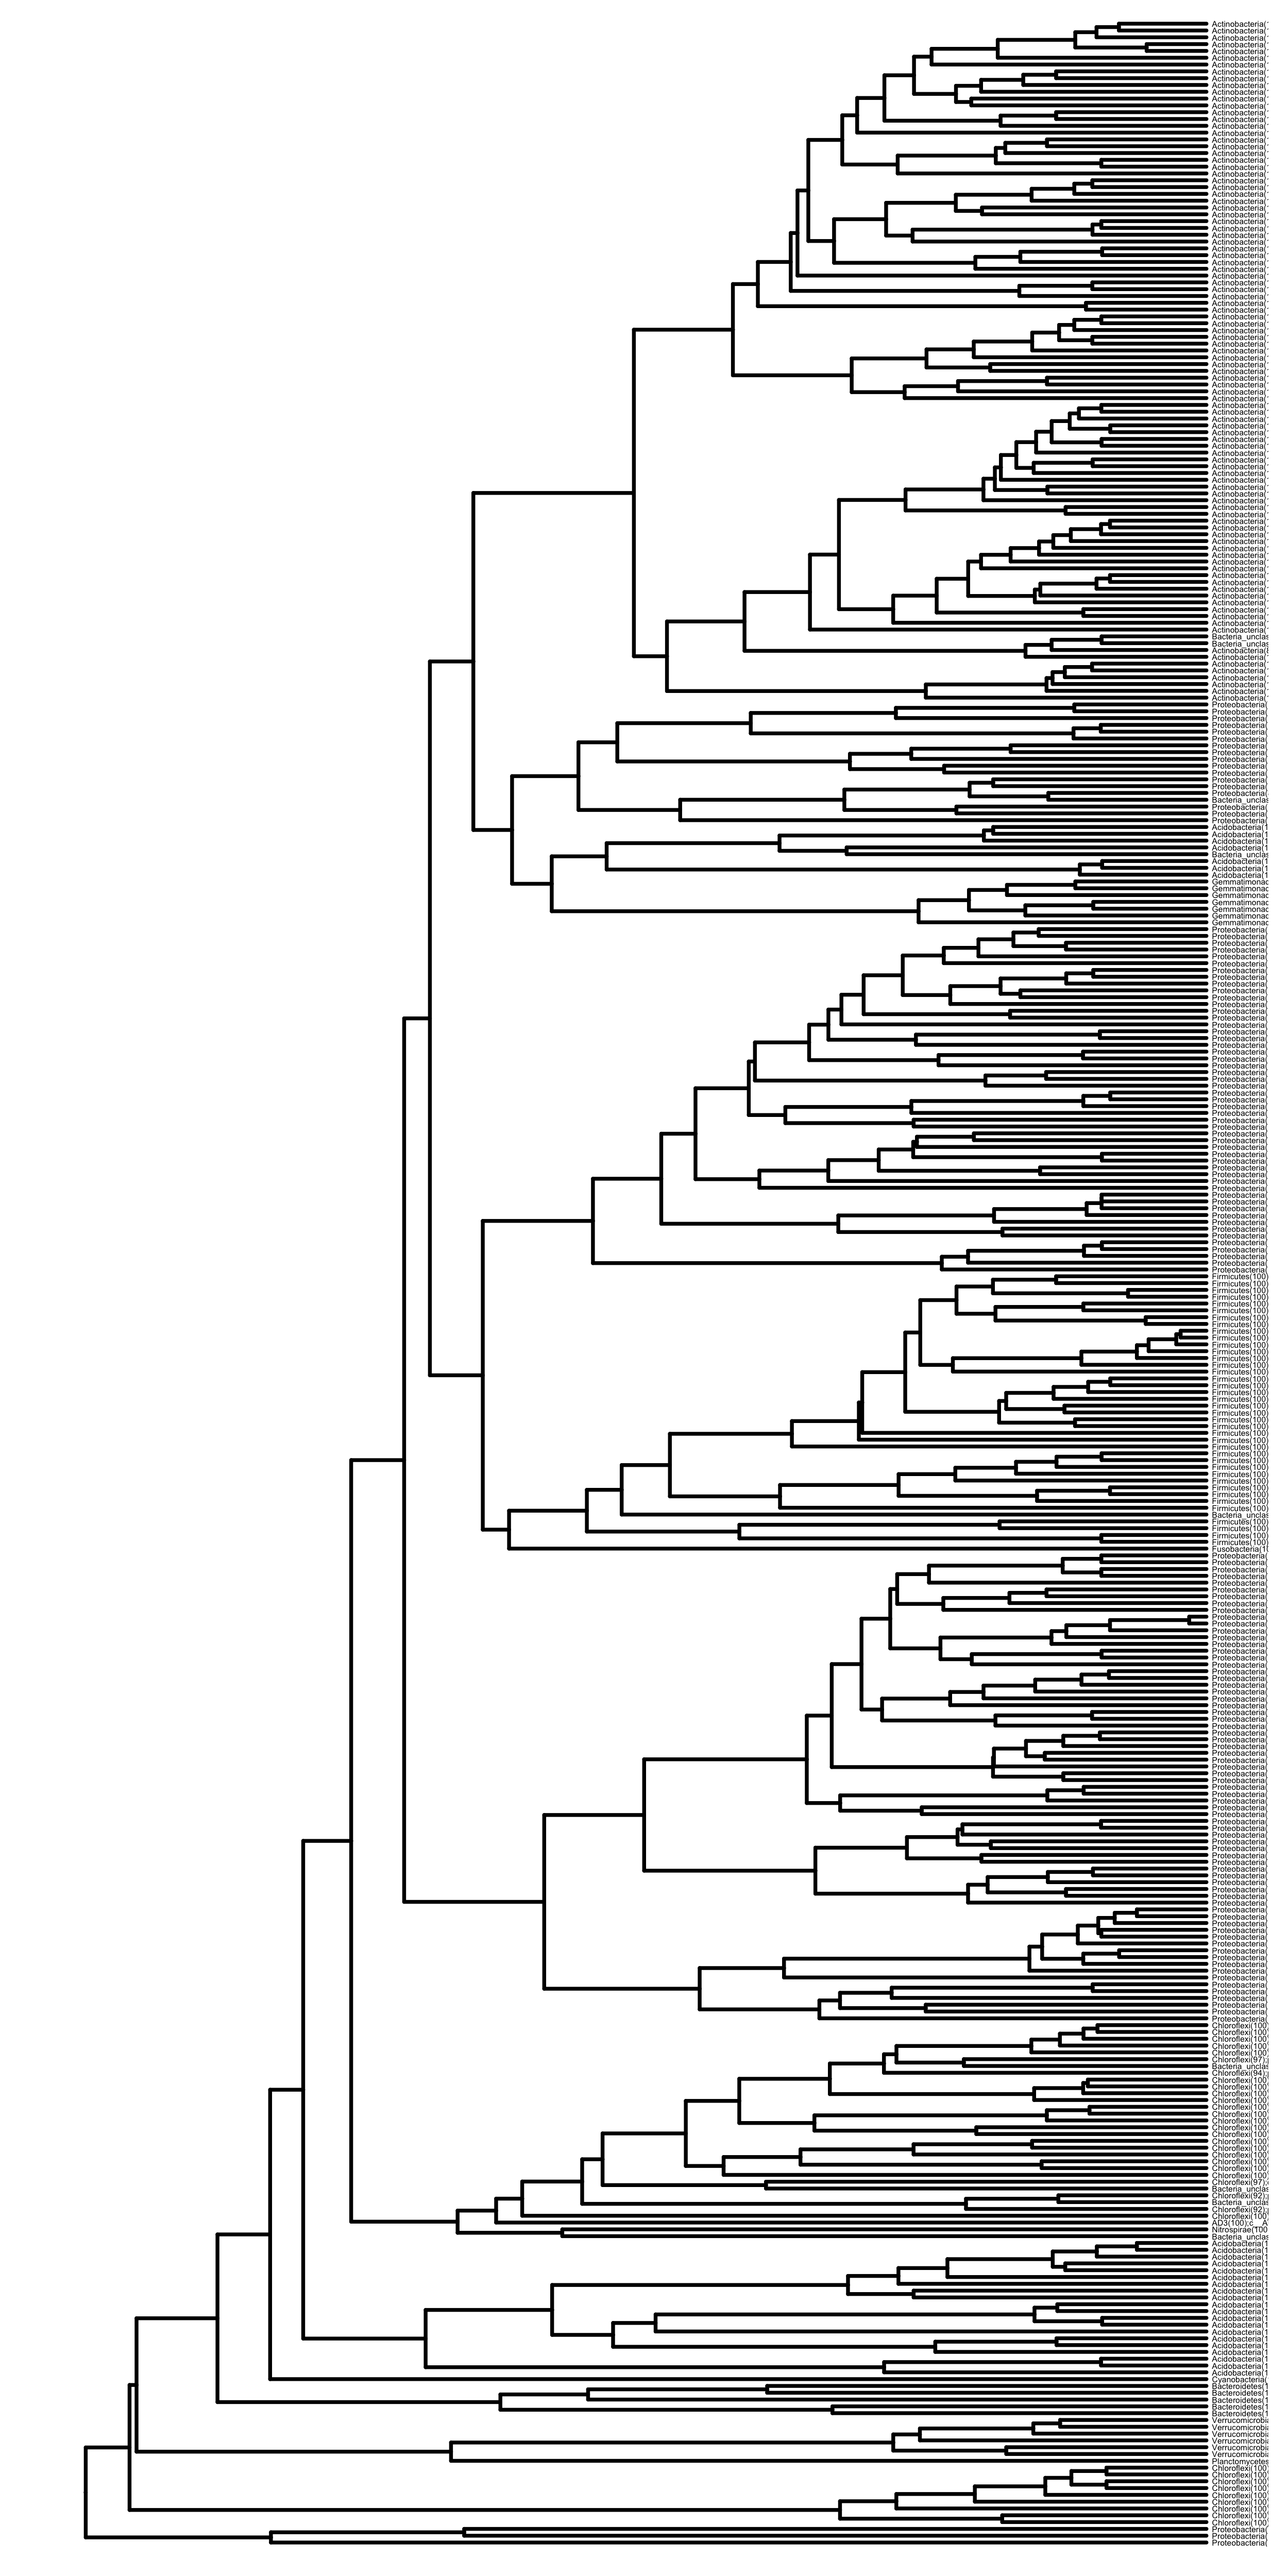

In [20]:
options(repr.plot.width=5, repr.plot.height=10,repr.plot.res=500)
ggtree(treeUPGMA) + geom_tiplab(size=0.8)

The `layout` parameter in ggtree defines the shape of the tree. Other options are: "slanted", "fan", "circular", "equal_angle", "daylight". 

**Exercise**: plot the same rooted tree with the parameter "fan".

In [ ]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=500)
# type your answer here

**Exercise**: plot the NJ tree in the "equal_angle" layout.

In [ ]:
# type your answer here

## Character based methods


Instead of a distance matrix, the difference among the nucleotides is computed and fitted to a substitution model. A tree that explains this model is fitted to the data. 

Advantages: 
- Uses all the information available in sequences at each homologous site
- Output measure of how good is the tree

Disadvantage:
- Computationally demanding

### Maximum parsimony

>The most believable or parsimonious phylogenetic tree will be the tree that invokes the smallest number of evolutionary changes during the divergence of the sequences it represents.


Compute the parsimony score for the two trees computed so far. The output integer for the `parsimony` function, given a tree and its corresponding alignment, is the parsimony score. The parsimony score is defined as the number of changes which are at least necessary to describe the data for a given tree. To get more information you can inspect the help page for the `parsimony` function by running `?parsimony` in the cell below.

In [ ]:
# type your answer here

In [ ]:
parsimony(treeUPGMA, alignment)
parsimony(treeNJ, alignment)

**Exercise**: which tree is more believable?

*type here your answer*

Use the function `optim.parsimony` which performs tree rearrangements to find trees with a lower parsimony score. The tree rearrangement implemented are
nearest-neighbor interchanges (NNI) and subtree pruning and regrafting (SPR). See the image below for more information.

![](figs/nni.png)

In [21]:
treePars  <- optim.parsimony(treeUPGMA, alignment)

Final p-score 6915 after  117 nni operations 


Perform the optimization but using the parsimony ratchet algorithm.

In [22]:
treeRatchet  <- pratchet(alignment, trace = 0)
parsimony(c(treePars, treeRatchet), alignment)

[1] 6915 6876

Print the parsimony score of both methods.

In [23]:
parsimony(c(treePars, treeRatchet), alignment)

[1] 6915 6876

**Exercise**: which optimization performs better? and which takes longer?

*type here your answer*

### Maximum likelihood

>The basic concept of likelihood is relatively simple to comprehend: given some data D (in our case, nucleotide or amino acid sequences), under a model of evolution, M (which is explicitly defined and describes the mutation process from one base to another), the likelihood of a set of parameters, θ (tree topology, tree branch lengths, substitution model parameters), corresponds to the probability of obtaining D under the model M with parameters θ. The maximum likelihood estimates of the parameter values included in θ correspond to the set of values that maximize this probability.

Calculate the maximum likelihood tree. The `pml` model contains the tree and different parameters of the model. 

In [24]:
fit = pml(treeNJ, data = alignment)

**Exercise**: explore the newly created fit object. What information does it tell us?

In [25]:
# type your answer here

Perform branch length optimization using Jukes-Cantor model (all base changes equally likely) with the function `optim.pml` and default values. First look at the help page of `optim.pml`.

In [26]:
# type your answer here

In [27]:
fitJC  <- optim.pml(fit, TRUE)

optimize edge weights:  -39310.35 --> -38465.35 
optimize edge weights:  -38465.35 --> -38463.56 
optimize topology:  -38463.56 --> -38166 
optimize topology:  -38166 --> -38022.35 
optimize topology:  -38022.35 --> -37960.99 
83 
optimize edge weights:  -37960.99 --> -37960.96 
optimize topology:  -37960.96 --> -37935.36 
optimize topology:  -37935.36 --> -37928.17 
optimize topology:  -37928.17 --> -37927.33 
17 
optimize edge weights:  -37927.33 --> -37927.32 
optimize topology:  -37927.32 --> -37925.91 
optimize topology:  -37925.91 --> -37925.91 
1 
optimize edge weights:  -37925.91 --> -37925.9 
optimize topology:  -37925.9 --> -37925.9 
0 
optimize edge weights:  -37925.9 --> -37925.83 
optimize edge weights:  -37925.83 --> -37925.83 


**Exercise**: obtain the log likelihood of the optimizied tree using the function `logLik` in the object `fitJC`. What does "df" mean?

In [28]:
# type your answer here

Change fitting to GTR model. 

In [29]:
fitGTR <- update(fit, k = 4, inv = 0.2)

**Exercise**: explore the `fitGTR`object just created. How does the log likelihood compared to the previous models used?

In [30]:
# type your answer here

Optimize all parameters to this model.

In [31]:
fitGTR <- optim.pml(fitGTR, model="GTR", optInv=TRUE, optGamma=TRUE,
                    rearrangement = "NNI", control = pml.control(trace = 0))

**Exercise**: explore the object after optimization, how did it change?

In [32]:
# type your answer here

**Exercise**: inspect the object fitGTR with the `attributes` function, where's the tree?

In [33]:
# type your answer here

In [34]:
options(repr.plot.width=5, repr.plot.height=9,repr.plot.res=500)

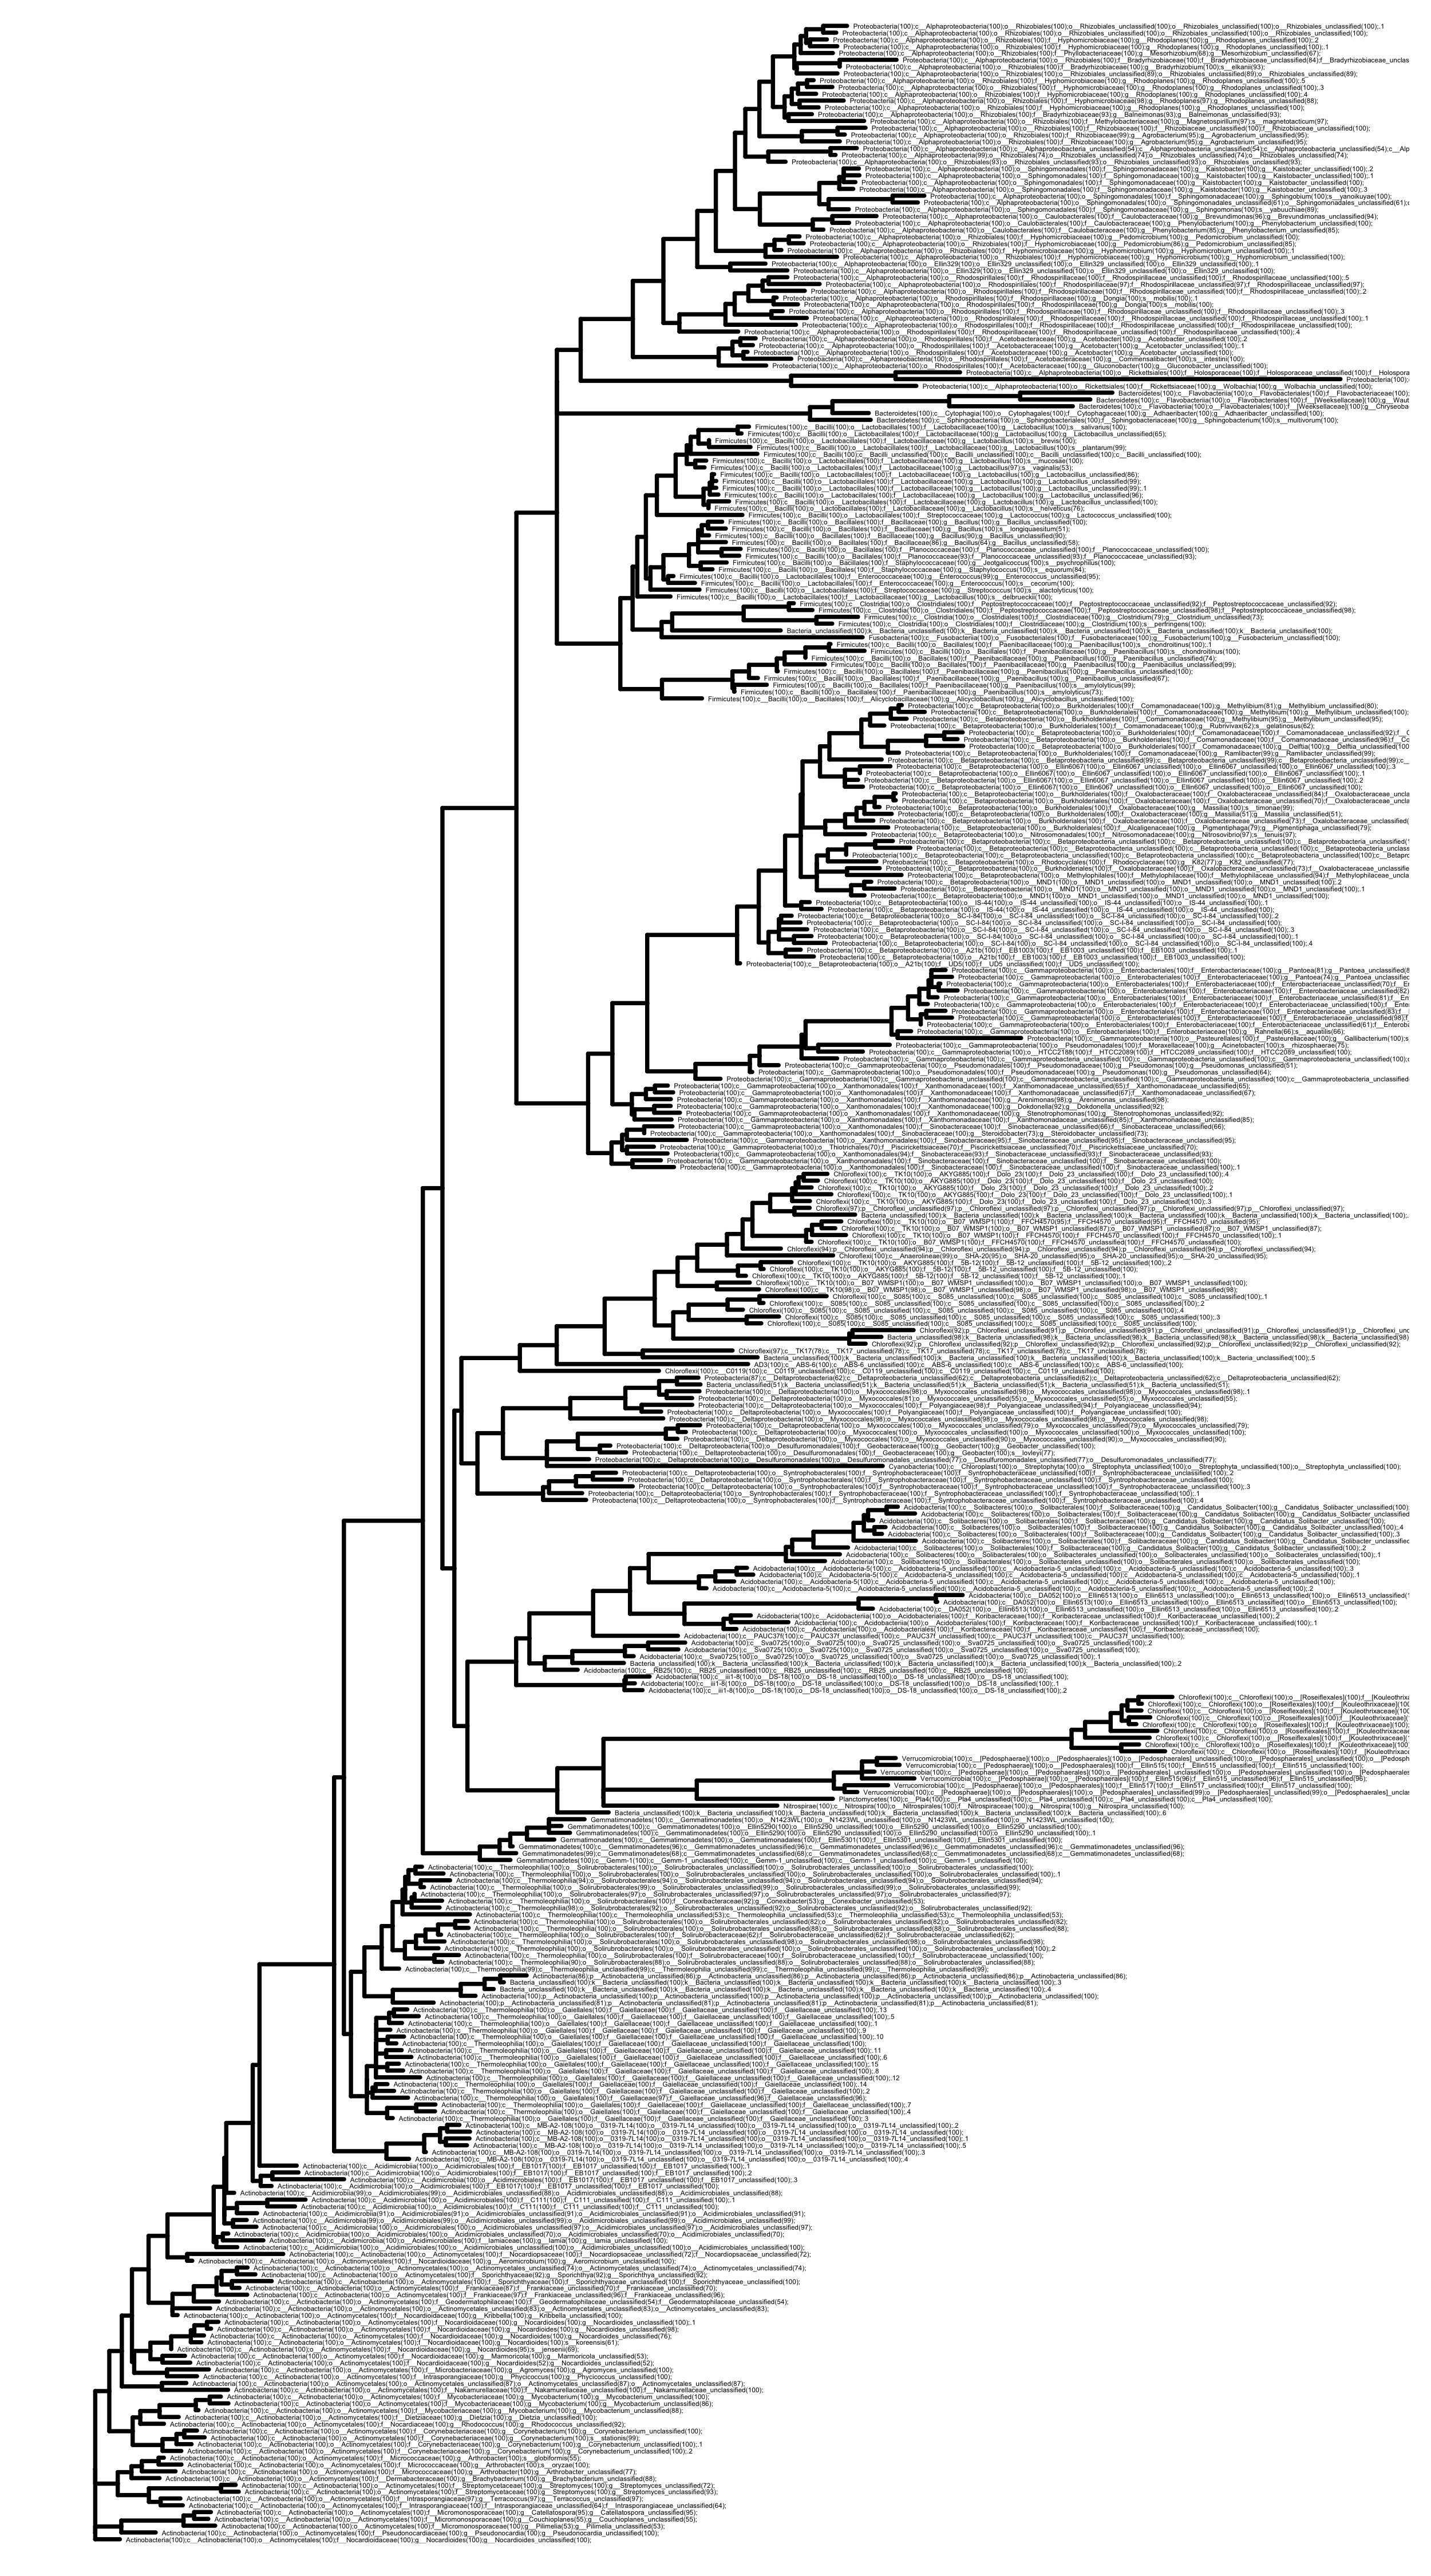

In [35]:
ggtree(fitGTR$tree) + geom_tiplab(size=0.6)

Trim the name of the leave to the first word (the phylum). This is done using a regex expression that removes everything after the first `(` (substitutes it by nothing).

In [36]:
fitGTR$tree$tip.label <- gsub('\\(.*$',"",fitGTR$tree$tip.label)

**Exercise**: explore the new names printing the object we just modified.

In [ ]:
# type here your answer

Plot the grouped OTUs, using the `groupOTU` function on some of the most abundant phyla before plotting the tree.

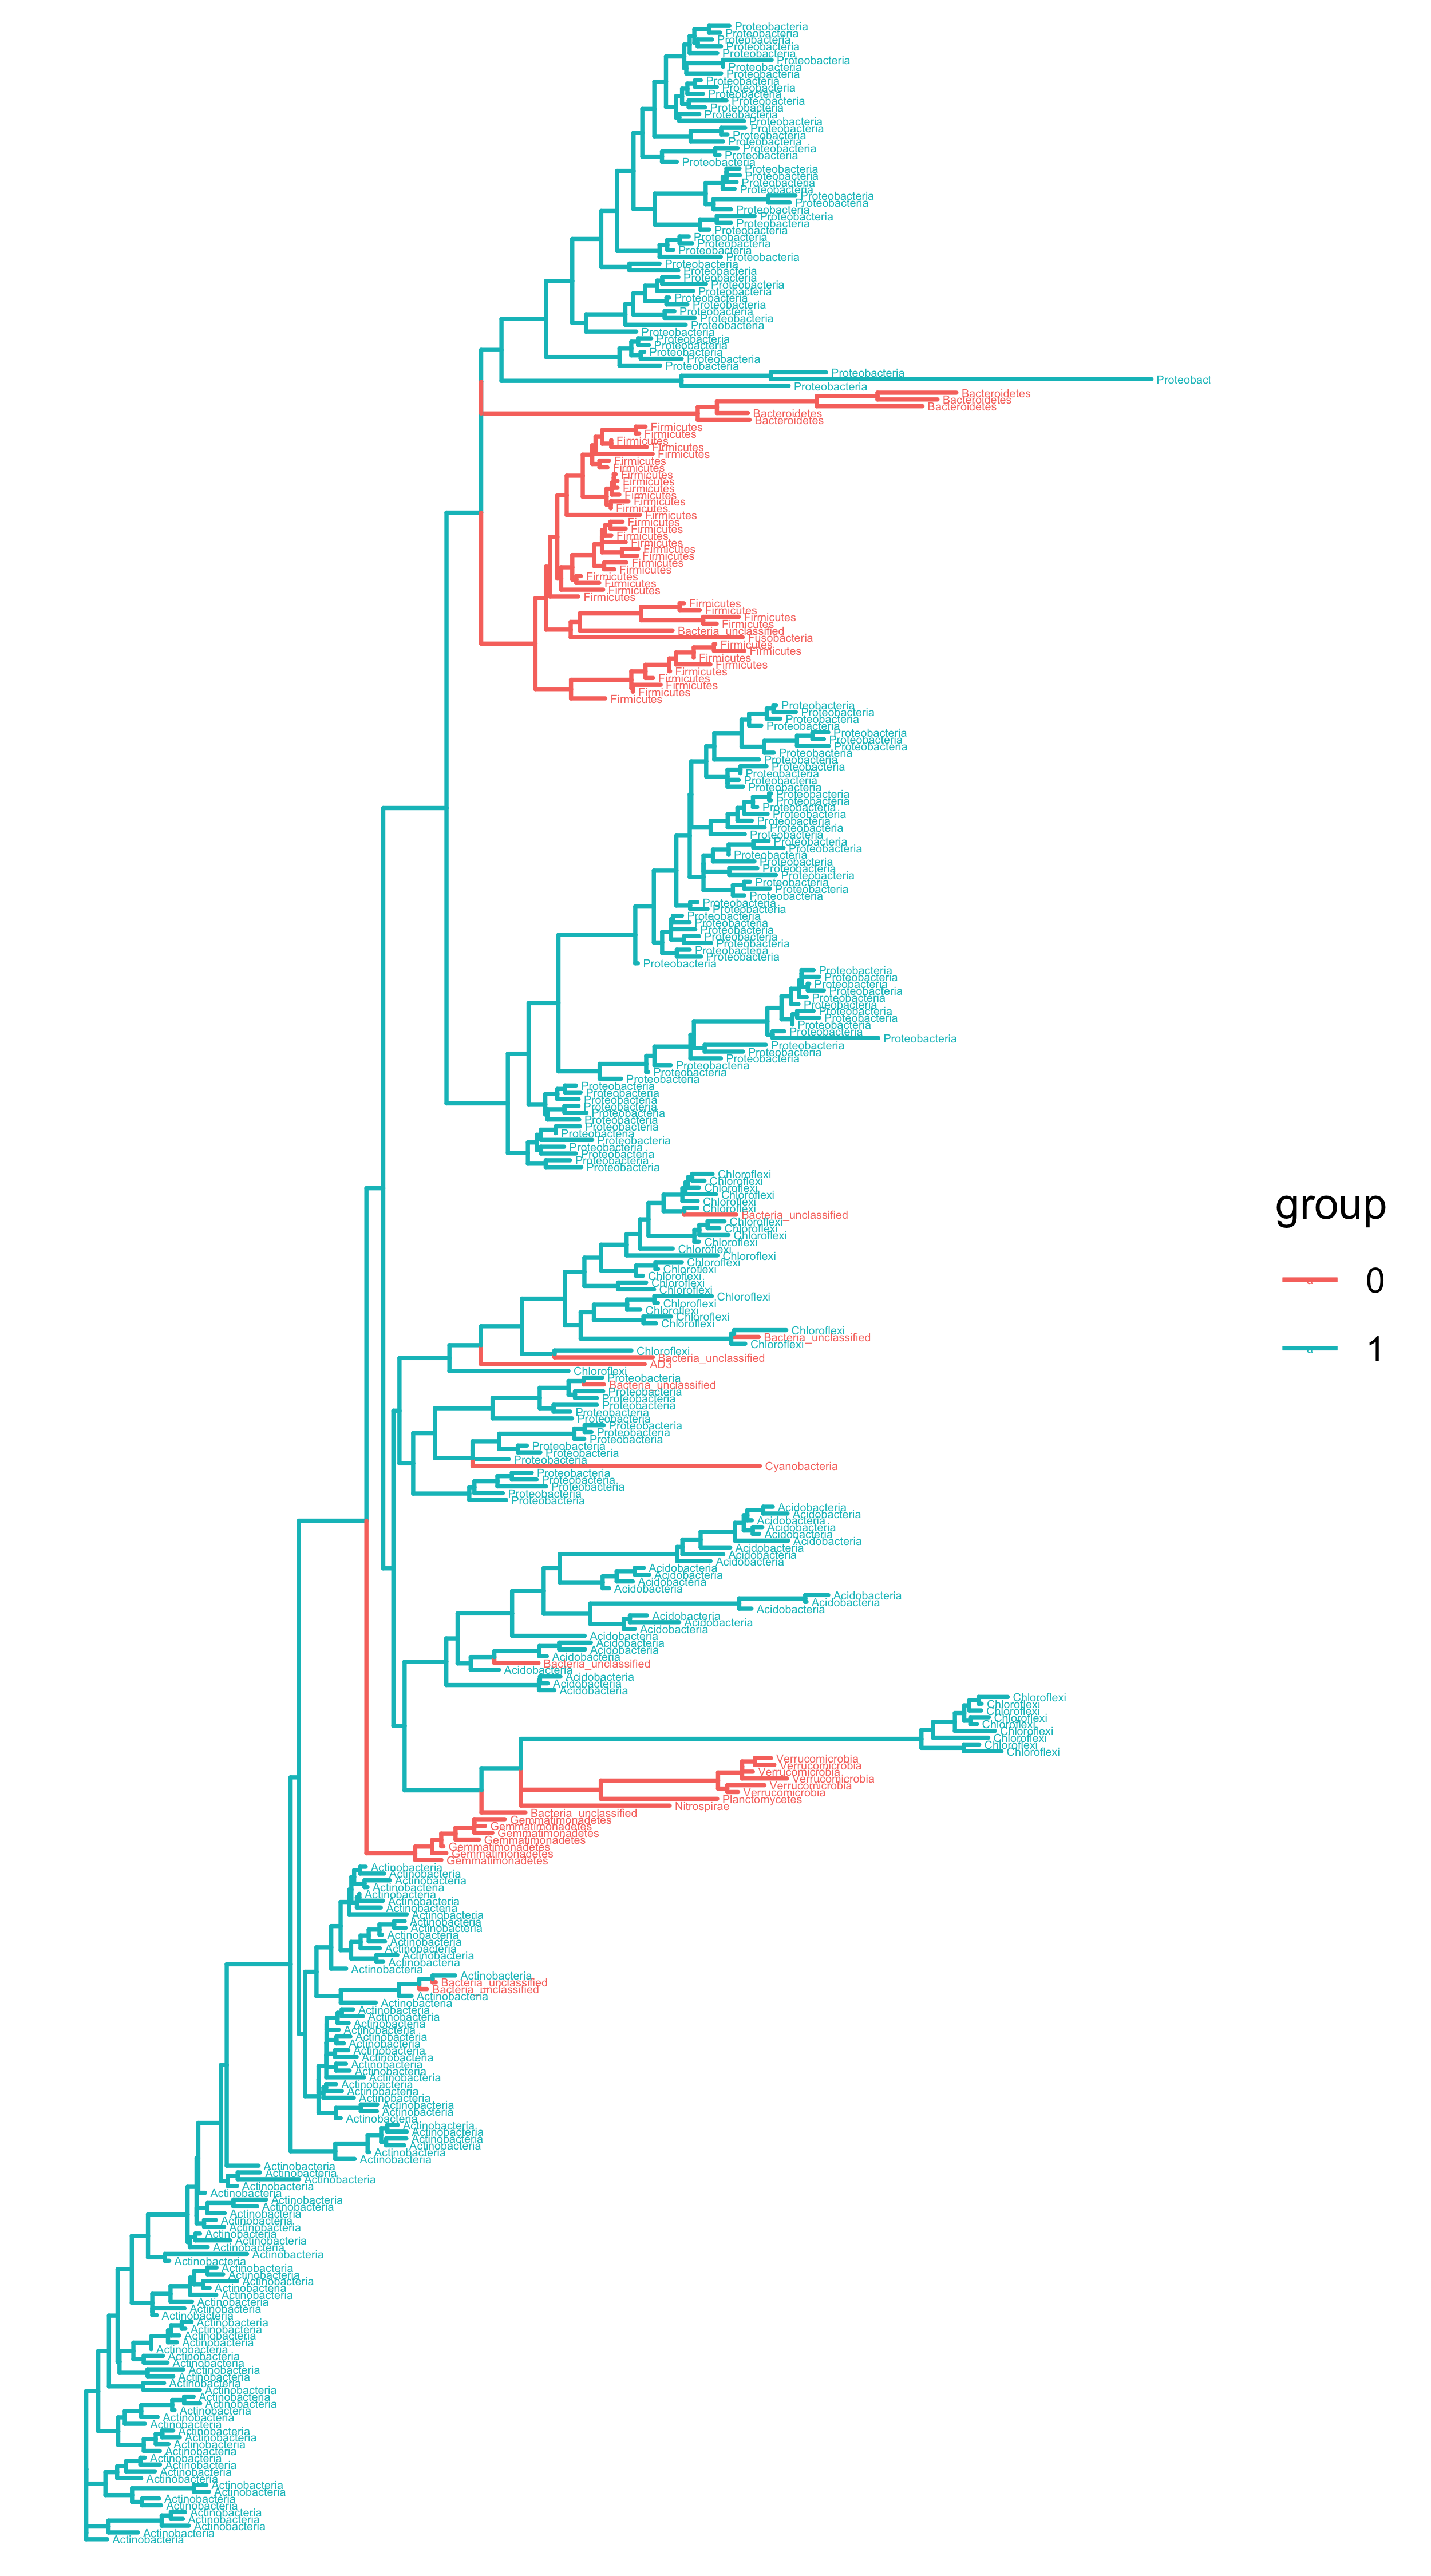

In [37]:
grouped_tree <- groupOTU(fitGTR$tree, c("Proteobacteria", "Actinobacteria", "Chloroflexi", "Acidobacteria"))

ggtree(grouped_tree, aes(color=group)) + geom_tiplab(size =1)

**Exercise**: what would you expect the unclassified OTU's to be?

*type here your answer*

Show label for all of the internal nodes.

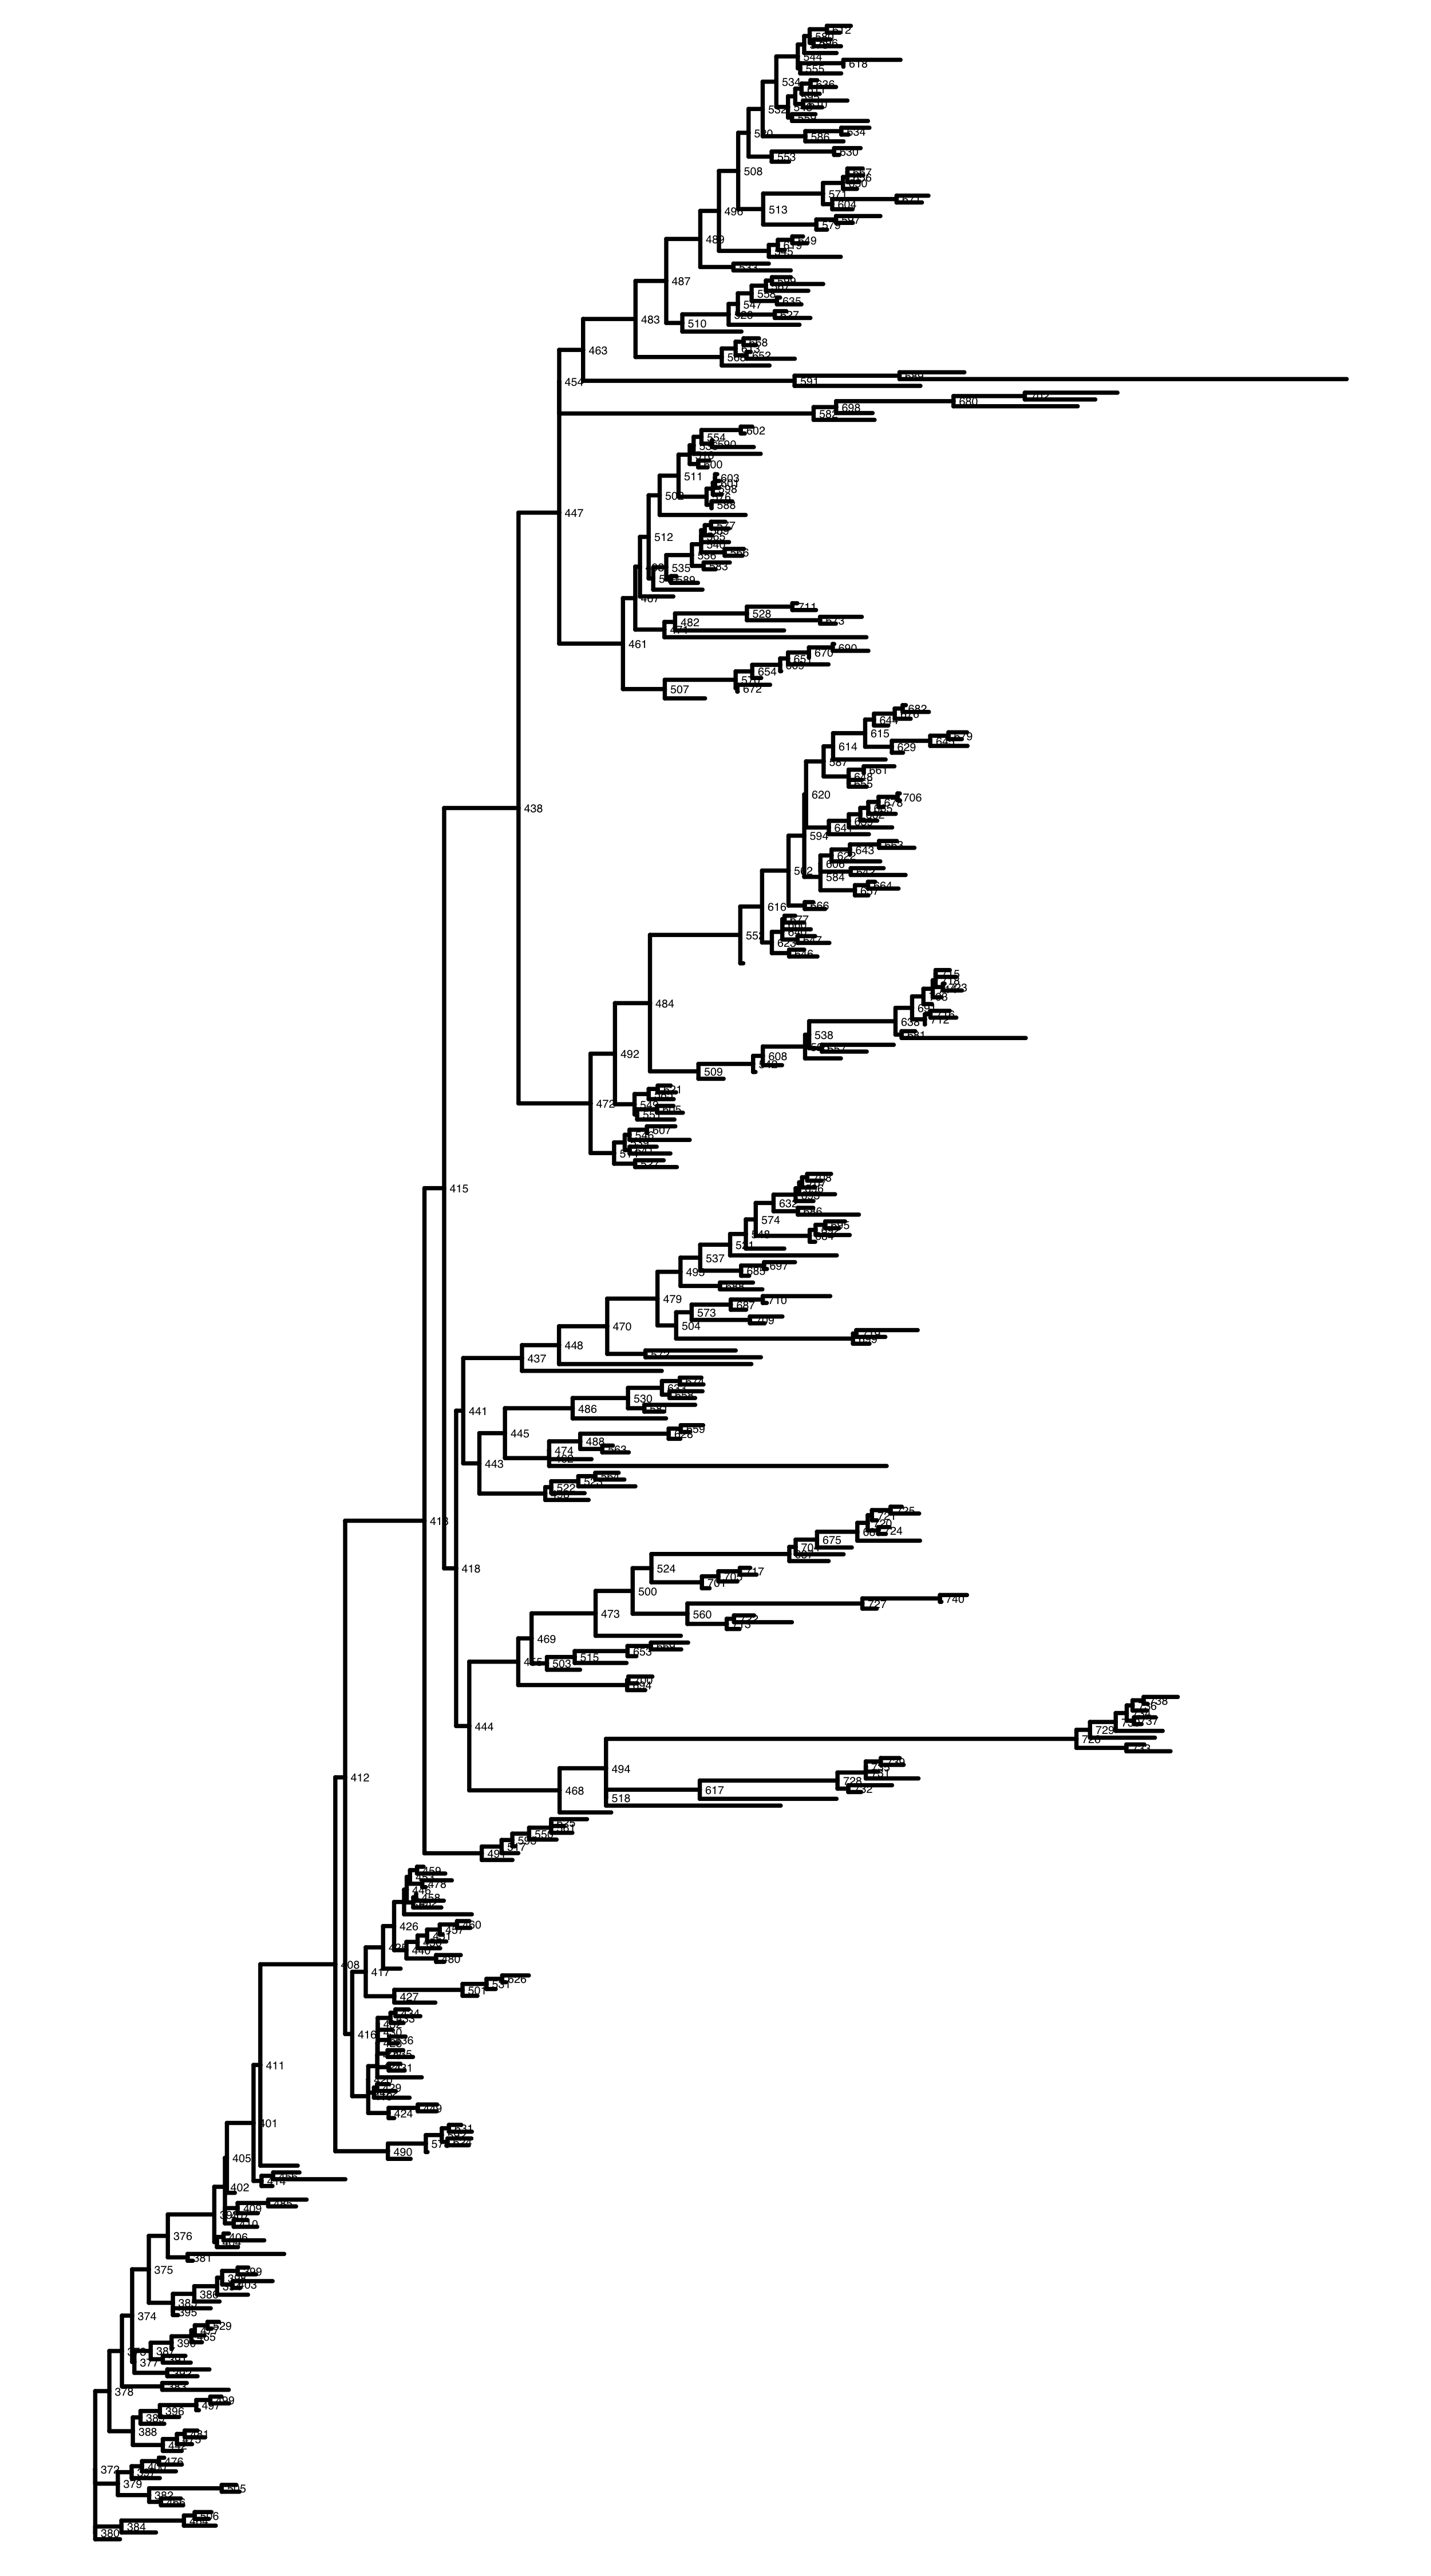

In [38]:
ggtree(fitGTR$tree) + geom_text2(aes(subset=!isTip, label=node), hjust=-.3, size = 1)

Highlight *betaproteobacteria* clade in green.

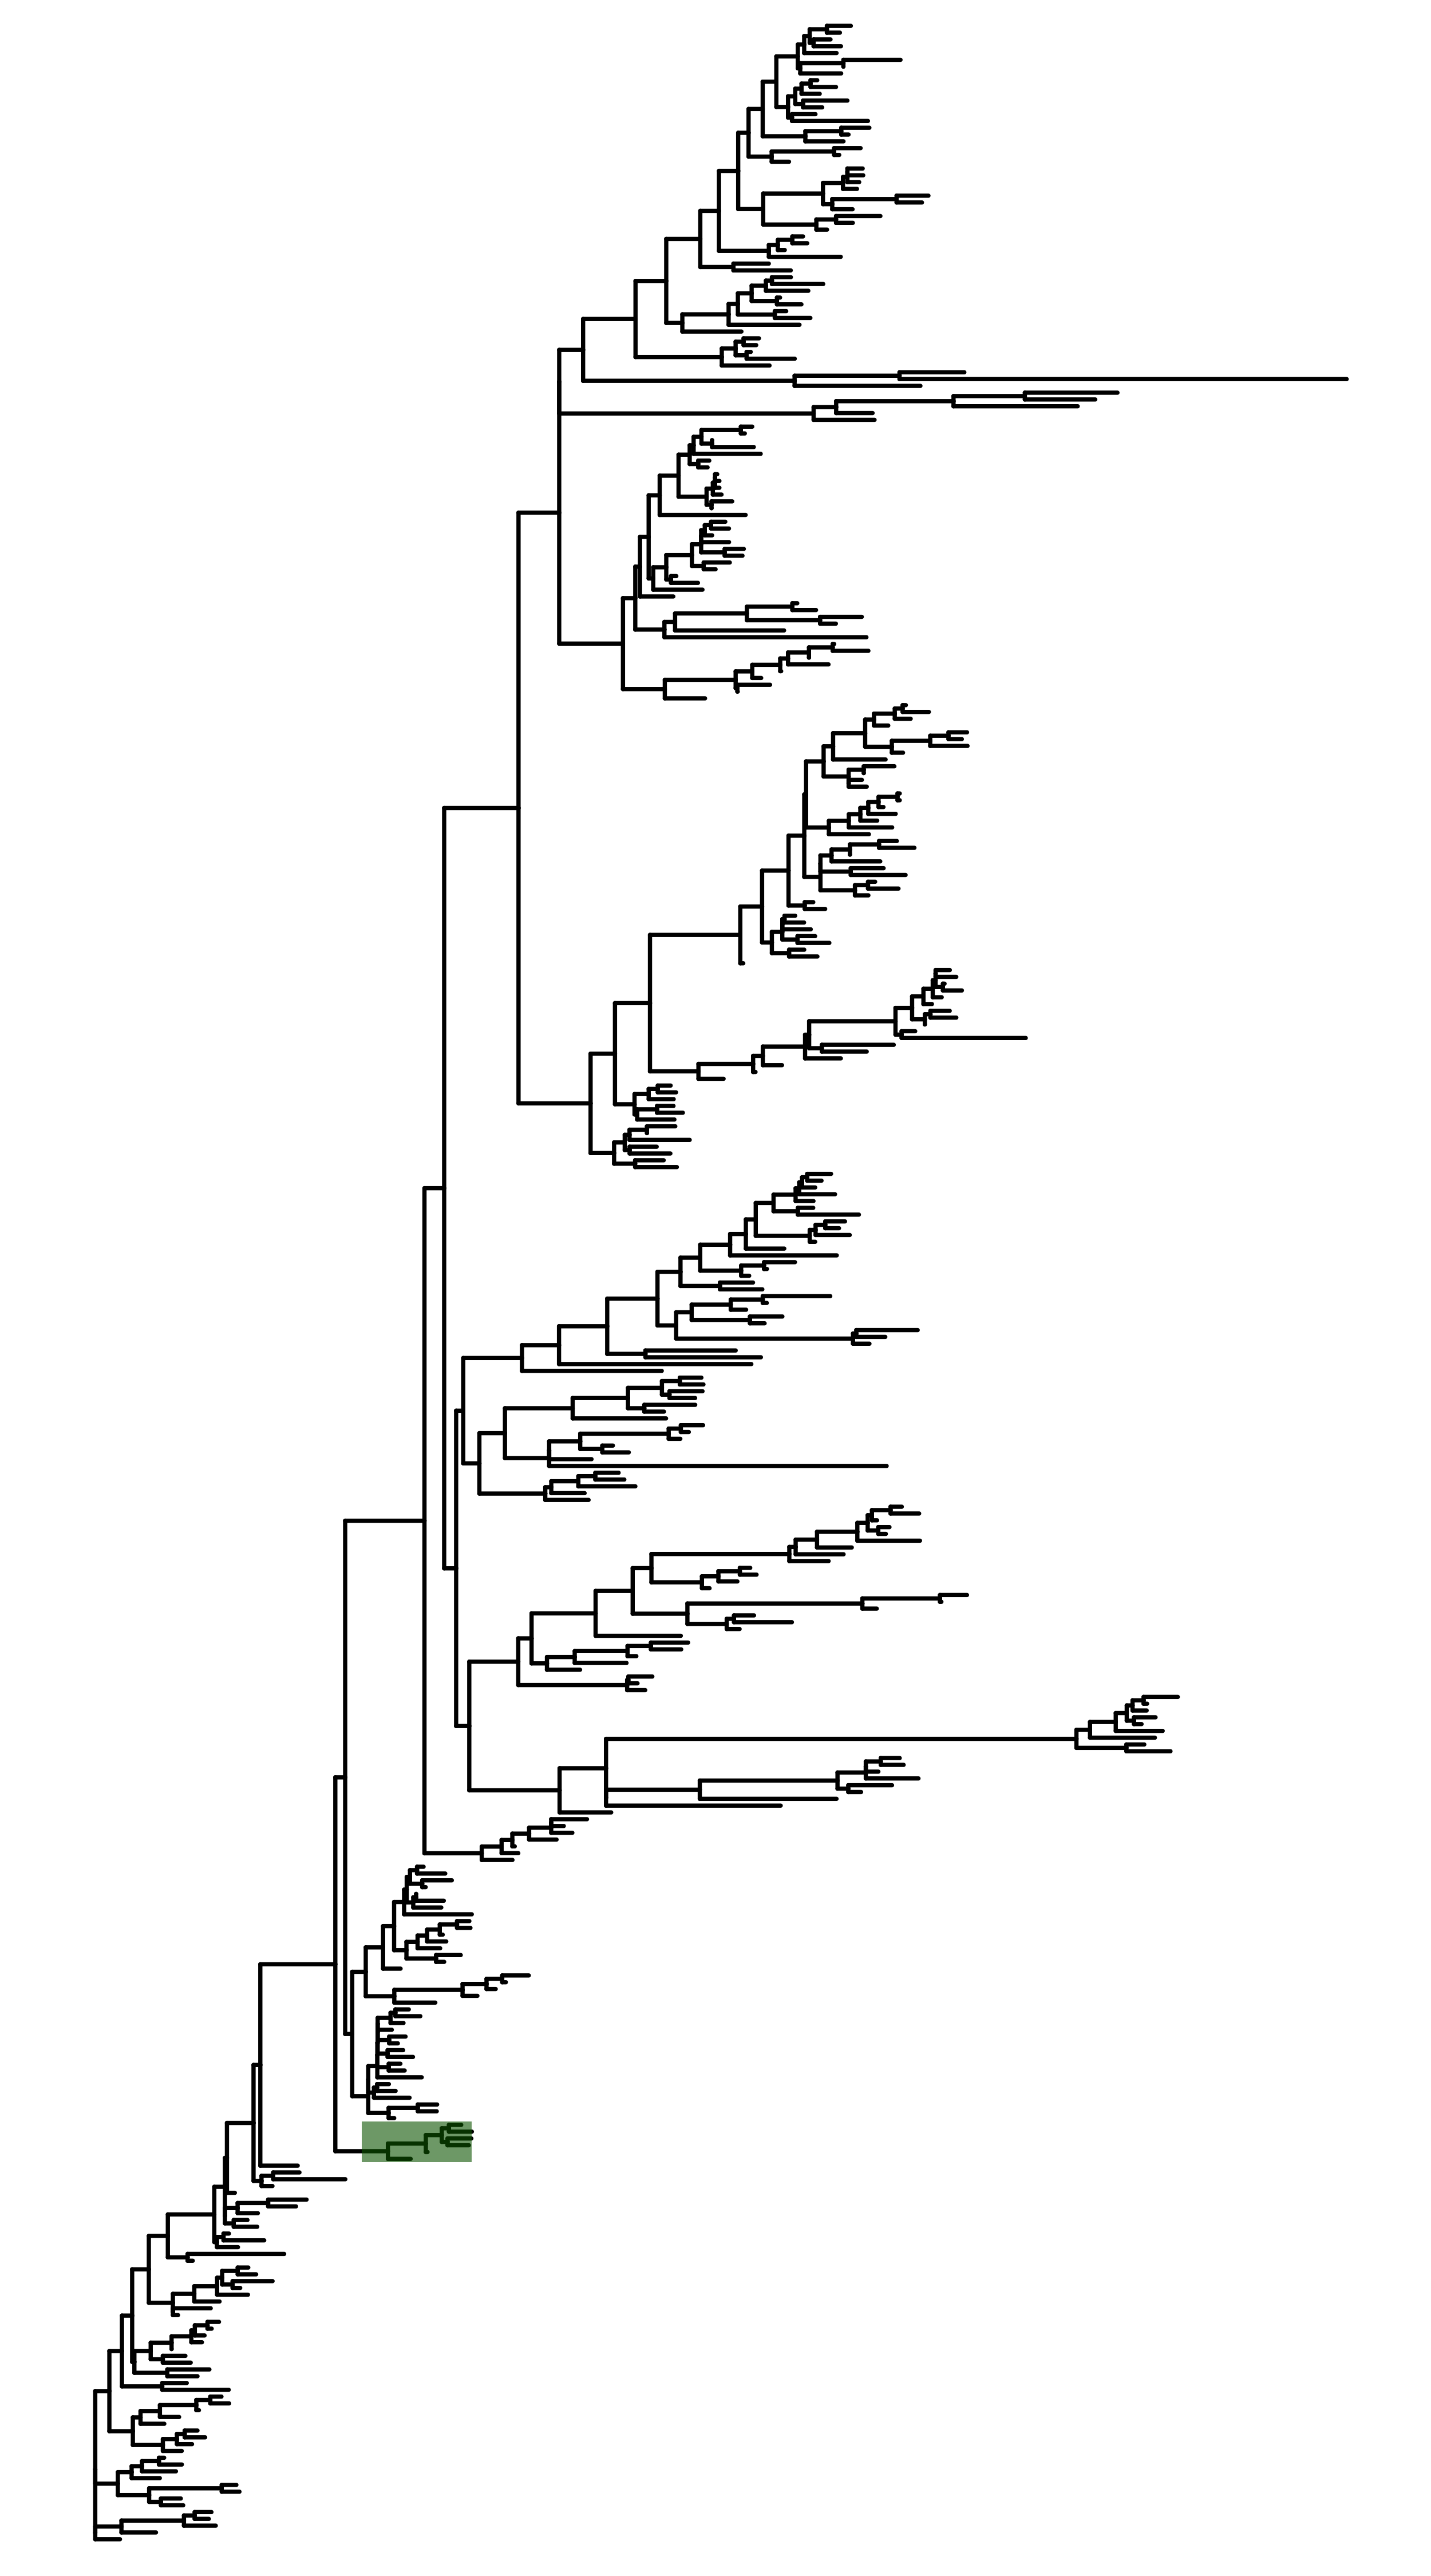

In [39]:
ggtree(fitGTR$tree) + geom_hilight(node=490, fill="darkgreen", alpha=.6) ## change the node number to fit the actual clade

**Exercise**: highlight also the *alphaproteobacteria* clade in blue.

In [ ]:
## type here your answer

## Model selection

![](figs/models.png) 

Compare nested models for JC and GTR using likelihood ratio statistic.

In [40]:
anova(fitJC, fitGTR)

Log lik.  Df  Df change Diff log lik. Pr(>|Chi|)
1 -37925.83 739 NA             NA       NA        
2 -30757.03 749 10        14337.6        0

Which nucleotide substitution model is more likely?

**Exercise**: read the help page for the `modelTest`function. What do the parameters multicore and m.core do?

In [ ]:
# type your answer here

Perform a model test (this may take a bit of time).

In [43]:
mt = modelTest(alignment)

[1] "JC+I"
[1] "JC+G"
[1] "JC+G+I"
[1] "F81+I"
[1] "F81+G"
[1] "F81+G+I"
[1] "K80+I"
[1] "K80+G"
[1] "K80+G+I"
[1] "HKY+I"
[1] "HKY+G"
[1] "HKY+G+I"
[1] "SYM+I"
[1] "SYM+G"
[1] "SYM+G+I"
[1] "GTR+I"
[1] "GTR+G"
[1] "GTR+G+I"


**Exercise**: inspect the results for the model test, which nucleotide substitution model is more likely?

In [ ]:
## type your answer here

## OTU table

Read the OTU table file.

In [44]:
otu_table <- read_delim("otu_info/BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.rep.count_table","\t")


── Column specification ───────────────────────────────────────────────────────────────────────────────
cols(
  Representative_Sequence = col_character(),
  total = col_double(),
  B5.145 = col_double(),
  B5.146 = col_double(),
  B5.147 = col_double(),
  B5.148 = col_double(),
  B5.149 = col_double(),
  B5.150 = col_double(),
  B5.151 = col_double(),
  B5.152 = col_double(),
  B5.153 = col_double(),
  B5.154 = col_double(),
  B5.155 = col_double(),
  B5.156 = col_double()
)




Add first column of the table to rownames.

In [111]:
otu_table <- column_to_rownames(otu_table, var = "Representative_Sequence")

**Exercise**: inspect the imported object, `otu_table`. What do the columns and rows mean?

In [ ]:
# type your answer here

**Exercise**: using the function `column_to_rownames` applied to the object `otu_table`, move the column first column called "Representative_Sequence" to the rownames. Name the result `otu_table` again. You may need to use the help page of `column_to_rownames` to find which parameter to add. 

In [ ]:
# type your answer here

Change to original sequence names back from the taxonomy.

In [95]:
bv5nt <- readDNAStringSet("otu_info/BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.rep.fasta")
bv5nt <- bv5nt[startsWith(names(bv5t), "k__Bacteria(100)")]
aln <- alignment
names(aln) <- names(bv5nt)

**Exercise**: how's the new object containing the original OTU names called?

In [ ]:
# type your answer here

Make a tree again using ML and the GTR substitution model.

In [106]:
treeNJ1  <- NJ(dist.ml(aln)) # constructs nj tree

fit1 = pml(treeNJ1, data=aln) # fits tree to alignment

fitGTR1 <- update(fit1, k=4, inv=0.2) 

fitGTR1 <- optim.pml(fitGTR1, model="GTR", optInv=TRUE, optGamma=TRUE,
                    rearrangement = "NNI", control = pml.control(trace = 0)) # fits tree to GTR substitution model

fitGTR1$tree$tip.label <- gsub('\t.*$',"",fitGTR1$tree$tip.label) # trims the names

**Exercise**: store tree figure with highlighted *alpha* and *proteobacteria clades*, this time using the newly created tree with annotated clades as `p` variable.

In [ ]:
# type your answer here

## Heatmap abundances

Plot the OTU table for the 12 samples as a heatmap of their abundance. Notice the log transformation on the OTU abundance.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



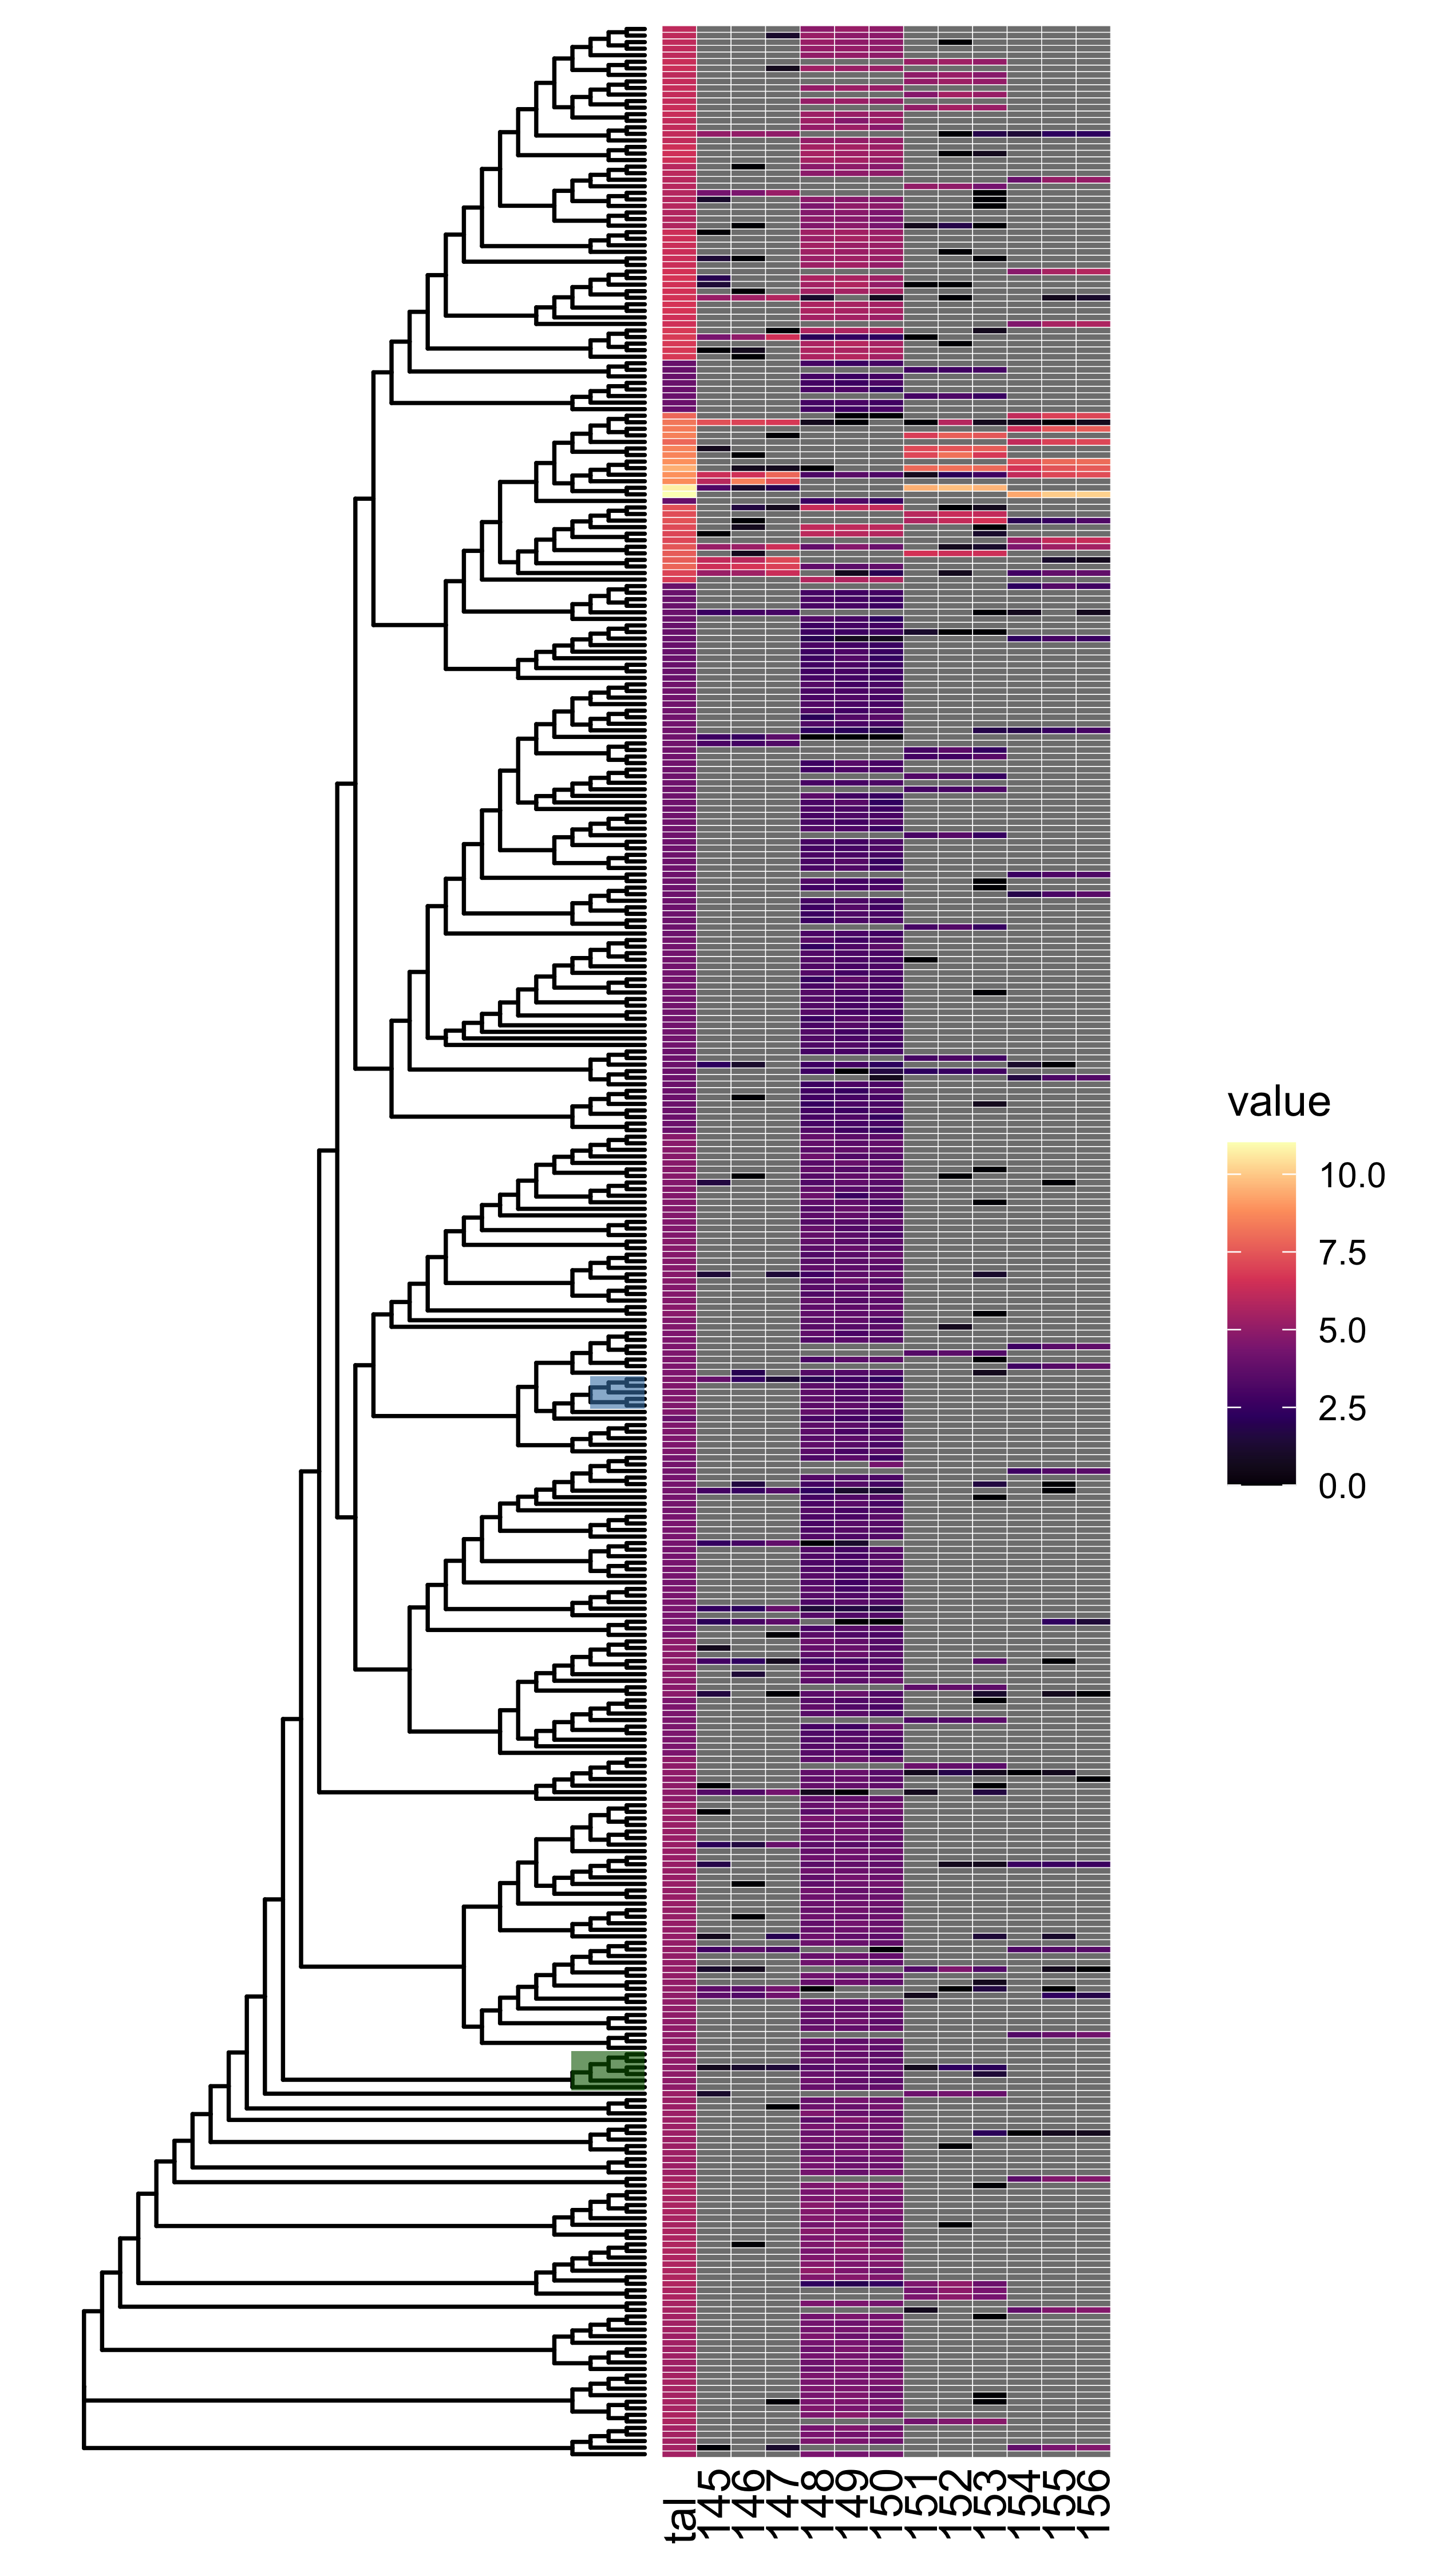

In [113]:
gheatmap(p,log(otu_table), 
         width =1,colnames_angle = 90, colnames_offset_y = -12) + 
scale_fill_viridis_c(option="A") 

**Exercise**: Add tip labels to the tree.

*tip: you can adjust font with the `size` parameter*.

In [ ]:
# type your answer here

**Exercise**: are the taxa abundances consistent along different types of sample? what are the more striking differences? 

How are *Pseudomonas*, *Corynebacterium* and *Acetobacter* distributed across the different samples?


*type here your answer*